In [7]:
import pandas as pd
import os
import pysubgroup as ps
import numpy as np
from bcb import sgs

In [4]:
# Junta todos os arquivos da série histórica que estão dentro de uma mesma pasta
path = "Dados/"
all_entries = os.listdir(path)
file_names = [entry for entry in all_entries if os.path.isfile(os.path.join(path, entry))]

itbi = pd.DataFrame({})
for file_name in file_names:
    temp_data = pd.read_csv(path+file_name, delimiter=";", low_memory=False)
    itbi = pd.concat([itbi, temp_data], axis=0)

itbi['Data Quitacao Transacao Formatada'] = pd.to_datetime(itbi['Data Quitacao Transacao'], format='%d/%m/%Y')
itbi['Ano Avaliacao'] = itbi['Data Quitacao Transacao Formatada'].dt.year
itbi['Mes Avaliacao'] = itbi['Data Quitacao Transacao Formatada'].dt.month
itbi.sort_values(by='Data Quitacao Transacao Formatada', ascending=True, inplace=True)

In [5]:
itbi = itbi.rename(columns={'Area Construida Adquirida': 'area',
                            'Padrao Acabamento Unidade': 'padrao',
                            'Valor Base Calculo': 'preco'})

# Padronização dos nomes
itbi['Bairro'] = itbi['Bairro'].str.strip().str.upper()
itbi['Descricao Tipo Ocupacao Unidade'] = itbi['Descricao Tipo Ocupacao Unidade'].str.strip().str.upper()

itbi.head()

,Endereco,Bairro,Ano de Construcao Unidade,Area Terreno Total,area,Area Adquirida Unidades Somadas,padrao,Fracao Ideal Adquirida,Tipo Construtivo Preponderante,Descricao Tipo Ocupacao Unidade,Valor Declarado,preco,Zona Uso ITBI,Data Quitacao Transacao,Data Quitacao Transacao Formatada,Ano Avaliacao,Mes Avaliacao
81,RUA SANTA CATARINA 1466 - APT 2601 - LOURDES -...,LOURDES,2007,"2.475,00","344,09","344,09",P5,"0,020319",AP,RESIDENCIAL,"875.000,00","879.448,67",ZCBH,02/01/2008,2008-01-02,2008,1
77,RUA PROFESSOR MIGUEL DE SOUZA 113 - APT 102 - ...,BURITIS,1996,450,"136,8","136,8",P3,"0,166667",AP,RESIDENCIAL,"90.000,00","97.904,43",ZAP,02/01/2008,2008-01-02,2008,1
76,RUA PONTE NOVA 624 - APT 401 - COLEGIO BATISTA...,COLEGIO BATISTA,2006,411,"220,15","220,15",P4,"0,20655",AP,RESIDENCIAL,"240.000,00","268.636,27",ZAP,02/01/2008,2008-01-02,2008,1
75,RUA PAULO KRUGER MOURAO 230 - BLOCO 7 APT 302 ...,JARDIM GUANABARA,2001,"10.199,00","49,14","49,14",P2,"0,003186",AP,RESIDENCIAL,"52.500,00","52.500,00",ZAR2,02/01/2008,2008-01-02,2008,1
74,RUA PATRICIO BARBOSA 783 - BLOCO A6 APT 302 - ...,CONJUNTO CALIFORNIA II,1982,"41.830,00",75,75,P2,"0,001544",AP,RESIDENCIAL,"25.850,00","28.461,47",ZAP,02/01/2008,2008-01-02,2008,1


In [6]:
# Cria as novas variáveis e filtra os dados

itbi['preco'] = itbi['preco'].str.replace(".", "", regex=False)
itbi['preco'] = itbi['preco'].str.replace(",", ".")
itbi['preco'] = itbi['preco'].astype(float)

itbi['area'] = itbi['area'].str.replace(".", "", regex=False)
itbi['area'] = itbi['area'].str.replace(",", ".")
itbi['area'] = itbi['area'].astype(float)

itbi = itbi.query("area >= 50")
itbi = itbi.query("preco >= 100000")
itbi = itbi.query("`Descricao Tipo Ocupacao Unidade` == 'RESIDENCIAL'")

itbi['idade'] = itbi['Ano Avaliacao'] - itbi['Ano de Construcao Unidade']
itbi['valor_m2'] = itbi['preco'] / itbi['area']

itbi = itbi.query("idade >= 0 and idade <= 100")

In [9]:
# Vamos trazer os preços dos imóveis para valor presente, pois precisamos comparar seus valores em anos diferentes

# Busca os dados do IGP-M pela biblioteca do banco central e cria o deflator
print("Buscando dados do IGP-M no Banco Central...")
igpm = sgs.get({'IGP-M': 189}, start='2008-01-01').rename(columns={'IGP-M': 'igpm_mensal'})
igpm['igpm_mensal'] = igpm['igpm_mensal'] / 100

data_referencia = igpm.index.max()
print(f"Todos os valores serão corrigidos para a data de referência: {data_referencia.strftime('%B de %Y')}")

valor_ref_acumulado = (1 + igpm['igpm_mensal']).cumprod().loc[data_referencia]
igpm['fator_acumulado'] = (1 + igpm['igpm_mensal']).cumprod()
igpm['fator_correcao'] = valor_ref_acumulado / igpm['fator_acumulado']
igpm['mes_ano'] = igpm.index.to_period('M')

# Aplicação do deflator pelo mês e ano de avaliação
itbi['mes_ano'] = itbi['Data Quitacao Transacao Formatada'].dt.to_period('M')

# Junta o fator de correção ao seu DataFrame principal
print("Juntando o fator de correção aos dados dos imóveis...")
itbi = pd.merge(itbi, igpm[['mes_ano', 'fator_correcao']], on='mes_ano', how='left')


# Aplica a correção e criar as novas colunas
print("Calculando os valores corrigidos...")
itbi['preco_corrigido'] = itbi['preco'] * itbi['fator_correcao']
itbi['valor_m2_corrigido'] = itbi['preco_corrigido'] / itbi['area']

print("\nCorreção inflacionária aplicada com sucesso usando o mês exato!")
itbi[["Ano Avaliacao", "Mes Avaliacao", 'preco', 'preco_corrigido', 'valor_m2', 'valor_m2_corrigido']].head()

Buscando dados do IGP-M no Banco Central...
Todos os valores serão corrigidos para a data de referência: May de 2025
Juntando o fator de correção aos dados dos imóveis...
Calculando os valores corrigidos...

Correção inflacionária aplicada com sucesso usando o mês exato!


,Ano Avaliacao,Mes Avaliacao,preco,preco_corrigido,valor_m2,valor_m2_corrigido
0,2008,1,879448.67,2.801609e+06,2555.868145,8142.080963
1,2008,1,268636.27,8.557790e+05,1220.241971,3887.254100
2,2008,1,361120.91,1.150402e+06,2119.005457,6750.392827
3,2008,1,365503.88,1.164365e+06,1261.532737,4018.791699
4,2008,1,311473.00,9.922415e+05,2166.617974,6902.069263


In [12]:
# Vamos realizar mais um refinamento nos dados: iremos eliminar os dados categóricos que aparecem poucas vezes
print(f"Tamanho original do dataset: {len(itbi):,}")

# Passo 1: Filtrar pelos tipos de imóvel de interesse
tipos_de_interesse = ['AP', 'CA']
itbi = itbi[itbi['Tipo Construtivo Preponderante'].isin(tipos_de_interesse)].copy()

print(f"Tamanho após filtrar por tipo de imóvel: {len(itbi):,}")

# Passo 2: Filtrar bairros com poucos imóveis
# Primeiro, contamos quantos imóveis cada bairro tem
contagem_bairros = itbi['Bairro'].value_counts()

# Definimos um limite mínimo. Podemos experimentar outros valores
limite_minimo_imoveis = 10 

# Pegamos a lista de bairros que ATENDEM ao critério
bairros_validos = contagem_bairros[contagem_bairros >= limite_minimo_imoveis].index

# Filtramos o DataFrame para manter apenas esses bairros
itbi = itbi[itbi['Bairro'].isin(bairros_validos)].copy()

print(f"Tamanho após remover bairros com menos de {limite_minimo_imoveis} imóveis: {len(itbi):,}")

Tamanho original do dataset: 312,468
Tamanho após filtrar por tipo de imóvel: 310,130
Tamanho após remover bairros com menos de 10 imóveis: 310,006


In [13]:
print(itbi.shape)
itbi.describe()

(310006, 23)


,Ano de Construcao Unidade,area,preco,Ano Avaliacao,Mes Avaliacao,idade,valor_m2,fator_correcao,preco_corrigido,valor_m2_corrigido
count,310006.000000,310006.000000,3.100060e+05,310006.000000,310006.000000,310006.000000,310006.000000,310006.000000,3.100060e+05,310006.000000
mean,2000.395450,140.600373,4.623389e+05,2016.409579,6.686345,16.014129,3275.190822,1.895691,8.112423e+05,5688.292313
std,16.519796,122.972651,4.607199e+05,4.939305,3.365309,16.433323,1461.598438,0.663360,7.939042e+05,2369.539065
min,1910.000000,50.000000,1.000000e+05,2008.000000,1.000000,0.000000,22.713571,1.007347,1.010952e+05,41.947270
25%,1990.000000,79.000000,2.200000e+05,2012.000000,4.000000,2.000000,2373.241336,1.121482,3.938624e+05,4109.908594
50%,2005.000000,118.000000,3.350000e+05,2016.000000,7.000000,10.000000,3157.693236,1.846793,5.913993e+05,5436.277368
75%,2013.000000,169.000000,5.350000e+05,2021.000000,10.000000,27.000000,3922.588316,2.438930,9.383352e+05,6807.820836
max,2024.000000,10189.340000,2.696200e+07,2024.000000,12.000000,98.000000,76550.212088,3.185642,4.630771e+07,187283.688939


In [38]:
# Iremos utilizar o ano de avaliação como variável categórica para termos acesso mais fácil à série histórica
print(f"Tipo original da coluna 'Ano Avaliacao': {itbi['Ano Avaliacao'].dtype}")

# CONVERTER O ANO PARA UM TIPO CATEGÓRICO (string é a forma mais simples)
itbi['Ano Avaliacao'] = itbi['Ano Avaliacao'].astype(str)

print(f"Novo tipo da coluna 'Ano Avaliacao': {itbi['Ano Avaliacao'].dtype}")

Tipo original da coluna 'Ano Avaliacao': int64
Novo tipo da coluna 'Ano Avaliacao': object


In [47]:
target = ps.NumericTarget('valor_m2')

# Variáveis utilizadas como seletores
# Categórica: Bairro, Padrão de Acabamento, Tipo do Imóvel
# Contínua: Ano de Avaliação e Idade
search_space = ps.create_selectors(itbi, ignore=['Endereco', 'Ano de Construcao Unidade', 'Area Terreno Total',
                                                 'area', 'Area Adquirida Unidades Somadas', 'Fracao Ideal Adquirida',
                                                 'Descricao Tipo Ocupacao Unidade', 'Valor Declarado', 'preco', 'Zona Uso ITBI',
                                                 'Data Quitacao Transacao', 'Data Quitacao Transacao Formatada', 'Mes Avaliacao',
                                                 'valor_m2', 'mes_ano', 'fator_correcao', 'preco_corrigido', 'valor_m2_corrigido',
                                                 'padrao'
                                                 ])

# Usaremos a StandardQF, que mede a diferença da média do subgrupo em desvios padrão
# O parâmetro 'a' ajuda a ponderar o tamanho do subgrupo.
quality_function = ps.StandardQFNumeric(a=0.5)

In [48]:
search_space

[Bairro=='LOURDES',
 Bairro=='COLEGIO BATISTA',
 Bairro=='SANTO AGOSTINHO',
 Bairro=='SION',
 Bairro=='FUNCIONARIOS',
 Bairro=='SERRA',
 Bairro=='NOVA FLORESTA',
 Bairro=='SANTO ANTONIO',
 Bairro=='SANTA LUCIA',
 Bairro=='CAICARA ADELAIDE',
 Bairro=='SAO BENTO',
 Bairro=='CALAFATE',
 Bairro=='BURITIS',
 Bairro=='SAGRADA FAMILIA',
 Bairro=='SANTA INES',
 Bairro=='GUTIERREZ',
 Bairro=='CAICARAS',
 Bairro=='CIDADE NOVA',
 Bairro=='CORACAO EUCARISTICO',
 Bairro=='BARRO PRETO',
 Bairro=='SAVASSI',
 Bairro=='BELVEDERE',
 Bairro=='LUXEMBURGO',
 Bairro=='PADRE EUSTAQUIO',
 Bairro=='DONA CLARA',
 Bairro=='SANTA TEREZA',
 Bairro=='UNIAO',
 Bairro=='PRADO',
 Bairro=='FLORESTA',
 Bairro=='NOVA SUISSA',
 Bairro=='ANCHIETA',
 Bairro=='VILA PARIS',
 Bairro=='ALIPIO DE MELO',
 Bairro=='BRAUNAS',
 Bairro=='CORACAO DE JESUS',
 Bairro=='BARREIRO',
 Bairro=='IPIRANGA',
 Bairro=='CENTRO',
 Bairro=='CASTELO',
 Bairro=='JARDIM AMERICA',
 Bairro=='SANTA AMELIA',
 Bairro=='BOA VIAGEM',
 Bairro=='SANTA MONICA',

In [49]:
# Criando a tarefa de descoberta de subgrupos
task = ps.SubgroupDiscoveryTask(
    itbi,
    target,
    search_space,
    result_set_size=10,  # Queremos os 10 melhores subgrupos
    depth=3,             # Profundidade máxima da descrição (ex: Bairro='SAVASSI' AND Tipo_Imovel='APARTAMENTO')
    qf=quality_function
)

# Executando a busca
result = ps.BeamSearch().execute(task)

In [61]:
media_global_nominal = itbi['valor_m2'].mean()
media_global_real = itbi['valor_m2_corrigido'].mean()
df_results = result.to_dataframe()
medias_reais_sg = []

for index, row in df_results.iterrows():
    subgrupo_obj = row['subgroup']
    dados_do_subgrupo = subgrupo_obj.covers(itbi)
    media_real = itbi[dados_do_subgrupo]['valor_m2_corrigido'].mean()
    medias_reais_sg.append(media_real)
df_results['mean_sg_corrigido'] = medias_reais_sg

print("="*60)
print("Análise Detalhada dos Subgrupos de Maior Impacto Nominal")
print("="*60)
print(f"Média Global Nominal: R$ {media_global_nominal:,.2f}")
print(f"Média Global Real (corrigida): R$ {media_global_real:,.2f}\n")


for index, row in df_results.iterrows():
    # Coletando os valores da linha
    qualidade = row['quality']
    descricao = row['subgroup']
    tamanho_subgrupo = row['size_sg']
    media_nominal_sg = row['mean_sg']
    media_real_sg = row['mean_sg_corrigido']

    # Calculando os dois impactos percentuais
    impacto_nominal = ((media_nominal_sg / media_global_nominal) - 1) * 100
    impacto_real = ((media_real_sg / media_global_real) - 1) * 100

    # Imprimindo o "card" de resultado para cada subgrupo
    print(f"Qualidade: {qualidade:.3f} | Subgrupo: {descricao}")
    print(f"   > Tamanho: {tamanho_subgrupo:,.0f} imóveis")
    print(f"   > Média Nominal: R$ {media_nominal_sg:,.2f}  (Impacto: {impacto_nominal:+.2f}%)")
    print(f"   > Média Real   : R$ {media_real_sg:,.2f}  (Impacto: {impacto_real:+.2f}%)")
    print("-" * 40)

Análise Detalhada dos Subgrupos de Maior Impacto Nominal
Média Global Nominal: R$ 3,275.19
Média Global Real (corrigida): R$ 5,688.29

Qualidade: 188762.214 | Subgrupo: Ano Avaliacao=='2024' AND Tipo Construtivo Preponderante=='AP'
   > Tamanho: 18,845 imóveis
   > Média Nominal: R$ 4,650.24  (Impacto: +41.98%)
   > Média Real   : R$ 4,898.04  (Impacto: -13.89%)
----------------------------------------
Qualidade: 185965.314 | Subgrupo: Ano Avaliacao=='2024'
   > Tamanho: 21,522 imóveis
   > Média Nominal: R$ 4,542.82  (Impacto: +38.70%)
   > Média Real   : R$ 4,784.52  (Impacto: -15.89%)
----------------------------------------
Qualidade: 145644.171 | Subgrupo: Bairro=='SAVASSI'
   > Tamanho: 5,992 imóveis
   > Média Nominal: R$ 5,156.70  (Impacto: +57.45%)
   > Média Real   : R$ 8,735.09  (Impacto: +53.56%)
----------------------------------------
Qualidade: 140687.785 | Subgrupo: Bairro=='SAVASSI' AND Tipo Construtivo Preponderante=='AP'
   > Tamanho: 5,939 imóveis
   > Média Nominal

In [62]:
# Vamos ver os resultados em gráficos para termos uma visualização melhor

import pandas as pd
import pysubgroup as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Cria uma lista para armazenar as médias reais
medias_reais = []

for index, row in df_results.iterrows():
    subgrupo_obj = row['subgroup']
    dados_do_subgrupo = subgrupo_obj.covers(itbi)
    media_real = itbi[dados_do_subgrupo]['valor_m2_corrigido'].mean()
    medias_reais.append(media_real)

# Adiciona a lista como uma nova coluna
df_results['mean_sg_corrigido'] = medias_reais

# Vamos pegar os 10 melhores resultados para plotar
top_10_results = df_results.head(10)

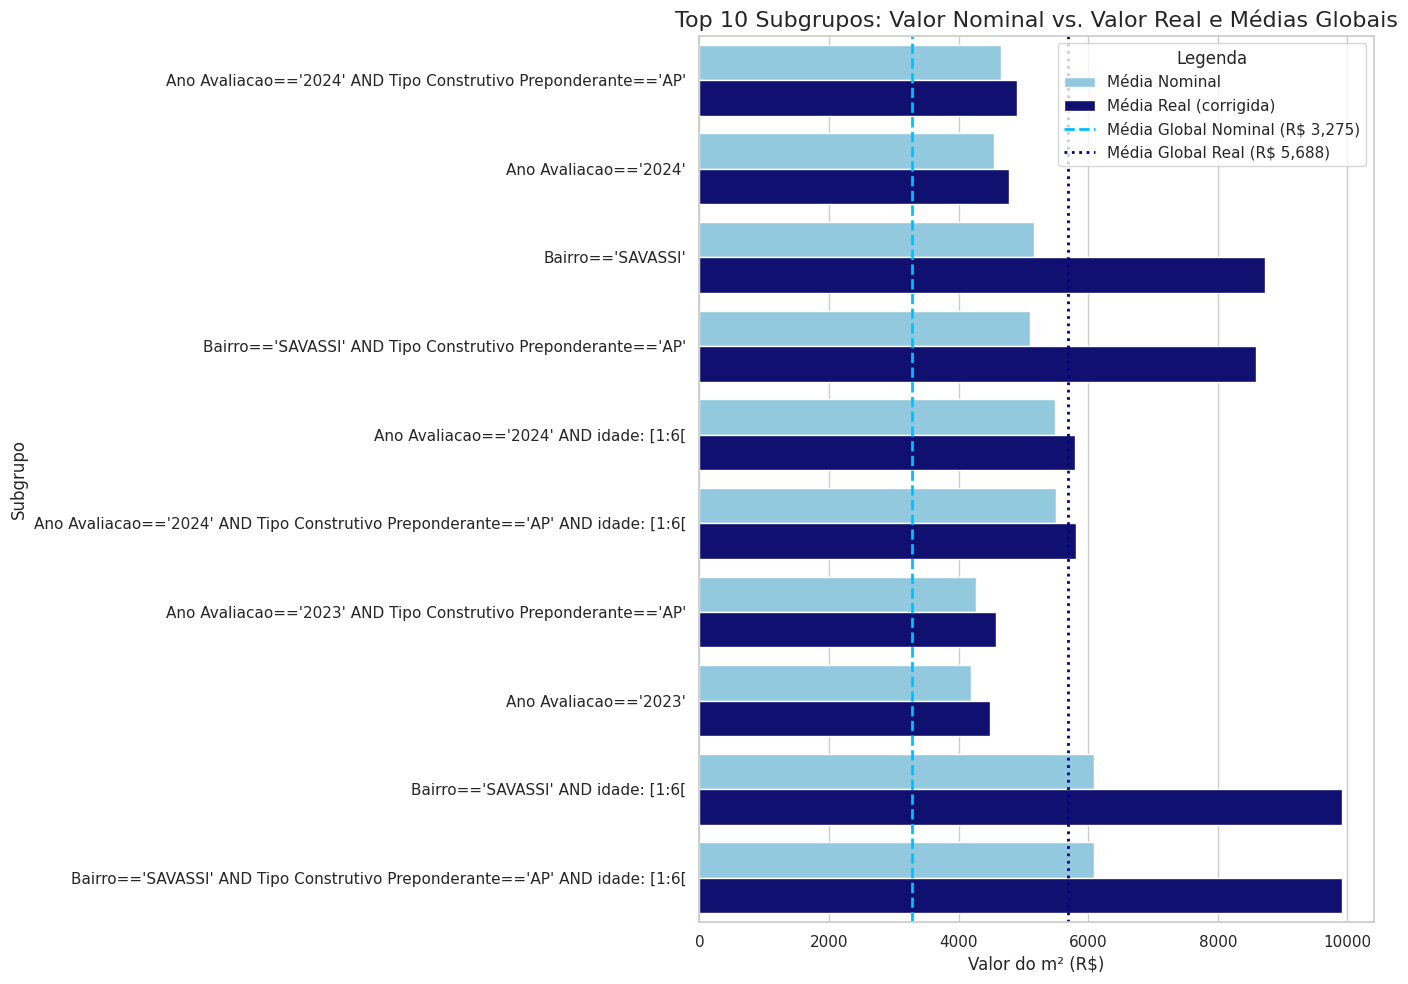

In [64]:
# Opção 1: Gráfico de Barras Agrupadas (Comparação Direta)
# Esta visualização é excelente para comparar diretamente o tamanho
# da barra do valor nominal com a do valor real para cada subgrupo

# Preparar os dados
df_plot = top_10_results[['subgroup', 'mean_sg', 'mean_sg_corrigido']].copy()
df_plot.rename(columns={
    'mean_sg': 'Média Nominal',
    'mean_sg_corrigido': 'Média Real (corrigida)'
}, inplace=True)

df_plot_long = pd.melt(
    df_plot,
    id_vars='subgroup',
    var_name='Tipo de Valor',
    value_name='Valor do m²'
)
# Criar o gráfico
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=df_plot_long, y='subgroup', x='Valor do m²', hue='Tipo de Valor', palette={'Média Nominal': 'skyblue', 'Média Real (corrigida)': 'navy'}, orient='h')

# --- ADIÇÃO DAS LINHAS DE MÉDIA GLOBAL ---
# Linha para a Média Nominal
ax.axvline(x=media_global_nominal, color='deepskyblue', linestyle='--', linewidth=2, label=f'Média Global Nominal (R$ {media_global_nominal:,.0f})')
# Linha para a Média Real
ax.axvline(x=media_global_real, color='darkblue', linestyle=':', linewidth=2, label=f'Média Global Real (R$ {media_global_real:,.0f})')

# Melhorar o layout
plt.title('Top 10 Subgrupos: Valor Nominal vs. Valor Real e Médias Globais', fontsize=16)
plt.xlabel('Valor do m² (R$)', fontsize=12)
plt.ylabel('Subgrupo', fontsize=12)
plt.legend(title='Legenda') # O legend() agora incluirá as linhas
plt.tight_layout()
plt.show()

*Como interpretar este gráfico*: Para cada subgrupo, você verá duas barras. A barra "Média Nominal" sempre será maior. O tamanho da barra "Média Real" em relação à nominal mostra o quanto da valorização foi "real" e o quanto foi apenas efeito da inflação.

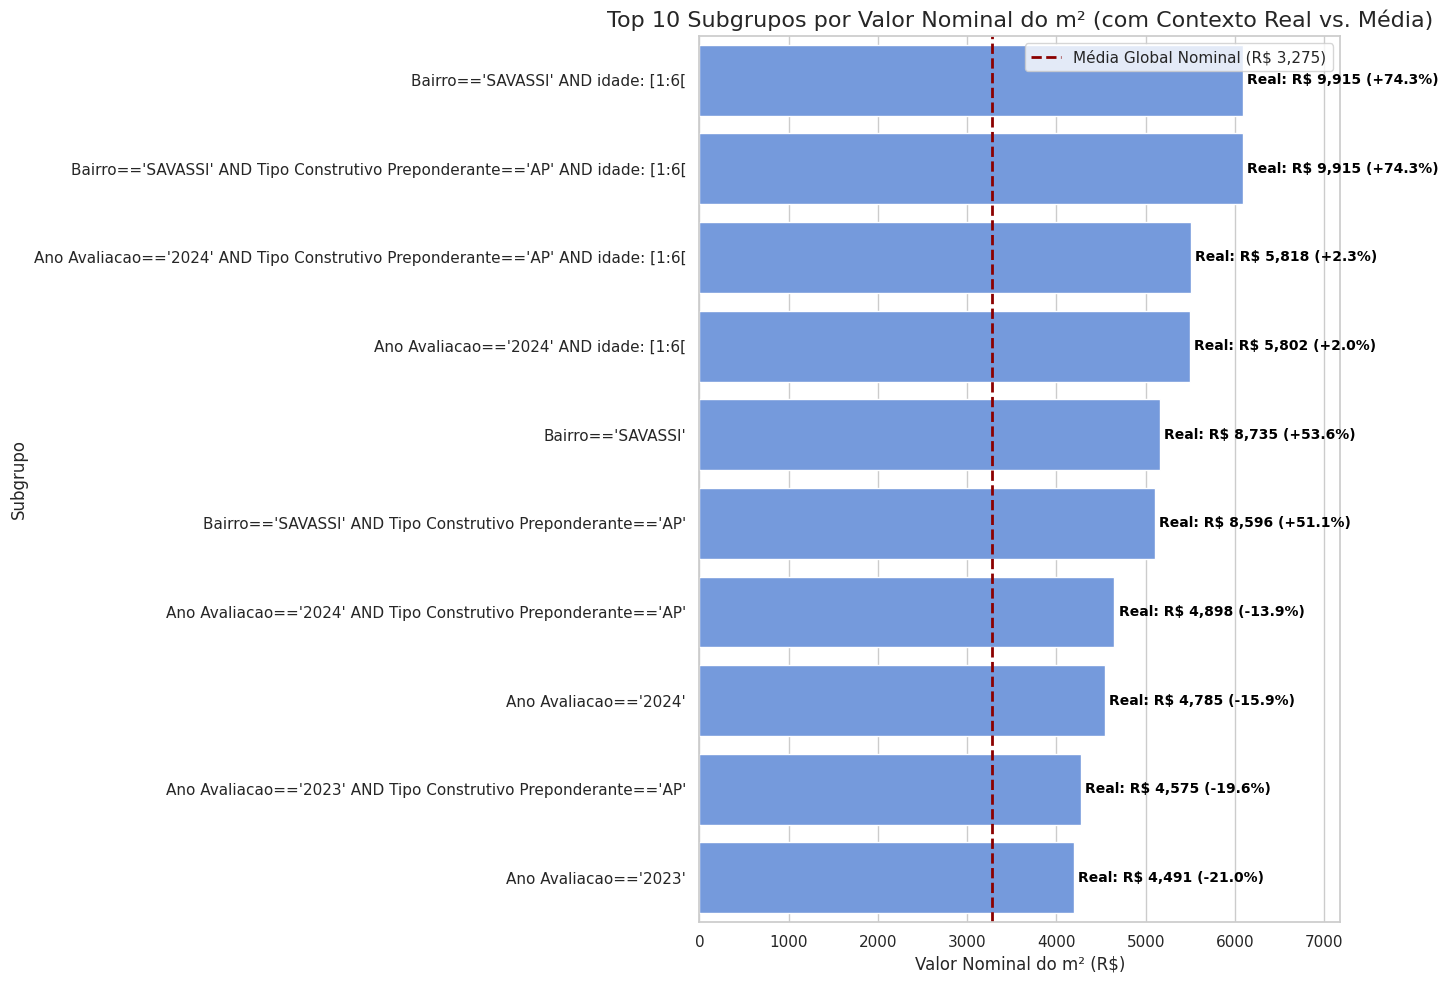

In [63]:
# Opção 2: Gráfico de Barras com Anotações (Foco no Ranking Nominal)
# Ordenando os dados para o gráfico
df_plot = top_10_results.sort_values(by='mean_sg', ascending=False)

plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

# Plotando as barras do VALOR NOMINAL
ax = sns.barplot(data=df_plot, y='subgroup', x='mean_sg', color='cornflowerblue', orient='h')

# --- ADIÇÃO DA LINHA DE MÉDIA NOMINAL ---
ax.axvline(x=media_global_nominal, color='darkred', linestyle='--', linewidth=2, label=f'Média Global Nominal (R$ {media_global_nominal:,.0f})')


# --- ANOTAÇÕES APRIMORADAS ---
for i, bar in enumerate(ax.patches):
    # Pega os valores real e nominal do subgrupo
    valor_real_sg = df_plot['mean_sg_corrigido'].iloc[i]
    
    # Calcula o impacto percentual do valor real do subgrupo em relação à média global real
    impacto_real_vs_media = ((valor_real_sg / media_global_real) - 1) * 100
    
    # Adiciona o texto no final da barra
    ax.text(
        bar.get_width() + 50,
        bar.get_y() + bar.get_height() / 2,
        f'Real: R$ {valor_real_sg:,.0f} ({impacto_real_vs_media:+.1f}%)', # Exibe o valor e o impacto
        ha='left', va='center', color='black', fontsize=10, weight='bold'
    )

# Melhorando o layout
plt.title('Top 10 Subgrupos por Valor Nominal do m² (com Contexto Real vs. Média)', fontsize=16)
plt.xlabel('Valor Nominal do m² (R$)', fontsize=12)
plt.ylabel('Subgrupo', fontsize=12)
plt.xlim(right=df_plot['mean_sg'].max() * 1.18) # Aumenta o espaço para o texto
plt.legend()
plt.tight_layout()
plt.show()

**Como interpretar este gráfico**: A ordem e o tamanho das barras mostram claramente quais subgrupos tiveram a maior "transformação nominal". O texto no final de cada barra rapidamente lhe informa qual era o valor "real" correspondente, permitindo uma análise de duas camadas em uma única visualização.